<a href="https://colab.research.google.com/github/RangerCoF/SparseConv/blob/main/ACC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("device=cuda")
else:
    device = torch.device("cpu")
    print("device=cpu")

device=cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
#    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
class ConvNetDataset(Dataset):
  def __init__(self, data, targets, device):
    self.data = data.to(device)
    self.targets = targets.to(device)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data = self.data[idx]
    targets = self.targets[idx]
    return data, targets

In [5]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
traindata = []
traintargets = []
for sample in trainset:
  traindata.append(sample[0])
  traintargets.append(sample[1])

traindata = torch.stack(traindata, dim=0)
traintargets = torch.tensor(traintargets)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testdata = []
testtargets = []
for sample in testset:
  testdata.append(sample[0])
  testtargets.append(sample[1])

testdata = torch.stack(testdata, dim=0)
testtargets = torch.tensor(testtargets)

In [6]:
class ConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(ConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=True)

    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(2, 2)
    self.norm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.norm(x)
    return x

class SparseConvBlock(nn.Module):
  def __init__(
      self,
      in_channels,
      out_channels,
      kernel_size,
      stride=1,
      padding='same',
      dilation=1):
    super(SparseConvBlock, self).__init__()

    self.conv = nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=kernel_size,
      stride=stride,
      padding=padding,
      dilation=dilation,
      bias=False)

    self.bias = nn.Parameter(
      torch.zeros(out_channels),
      requires_grad=True)

    self.sparsity = nn.Conv2d(
      in_channels=1,
      out_channels=1,
      kernel_size=kernel_size,
      padding=padding,
      dilation=dilation,
      bias=False)
    kernel = torch.FloatTensor(torch.ones([kernel_size, kernel_size])).unsqueeze(0).unsqueeze(0)
    self.sparsity.weight = nn.Parameter(
      data=kernel,
      requires_grad=False)

    self.relu = nn.ReLU(inplace=True)
    self.pool = nn.MaxPool2d(2, 2)
    self.norm = nn.BatchNorm2d(out_channels)

  def forward(self, x, mask):
    x = self.conv(x * mask)
    normalizer = self.sparsity(mask) + 1e-8
    x = x / normalizer + self.bias.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    x = self.relu(x)
    x = self.pool(x)
    x = self.norm(x)
    mask = self.pool(mask)
    return x, mask


In [7]:
class ConvNet(nn.Module):
    def __init__(self):
      super(ConvNet, self).__init__()
      self.conv1 = ConvBlock(1, 6, 5, padding='same')
      self.conv2 = ConvBlock(6, 16, 5, padding='same')


      self.fc1 = nn.Linear(16 * 7 * 7, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      x = x[:, :-1, :, :]

      x = self.conv1(x)

      x = self.conv2(x)

      x = x.view(-1, 16 * 7 * 7)
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

class SparseConvNet(nn.Module):
    def __init__(self):
      super(SparseConvNet, self).__init__()
      self.conv1 = SparseConvBlock(1, 6, 5, padding='same')
      self.conv2 = SparseConvBlock(6, 16, 5, padding='same')


      self.fc1 = nn.Linear(16 * 7 * 7, 120)
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      mask = x[:, -1:, :, :]
      x = x[:, :-1, :, :]

      x, mask = self.conv1(x, mask)

      x, mask = self.conv2(x, mask)
      # print(x.shape)
      # print(mask.shape)

      x = x.view(-1, 16 * 7 * 7)
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

In [8]:
prob_list = np.arange(0, 1, 0.05)
acc_conv = []

for prob in tqdm(prob_list):
  trainmask = torch.bernoulli(torch.full(traindata.shape, 1 - prob))
  trainset_input = torch.cat((traindata * trainmask, trainmask), dim=1)
  trainset = ConvNetDataset(trainset_input, traintargets, device)

  testmask = torch.bernoulli(torch.full(testdata.shape, 1 - prob))
  testset_input = torch.cat((testdata * testmask, testmask), dim=1)
  testset = ConvNetDataset(testset_input, testtargets, device)

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
  net = ConvNet().to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

  for epoch in range(2):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

  print('Finished Training')

  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc_conv.append(correct / total)



  0%|          | 0/20 [00:00<?, ?it/s]

Finished Training


  5%|▌         | 1/20 [00:07<02:20,  7.42s/it]

Finished Training


 10%|█         | 2/20 [00:14<02:11,  7.30s/it]

Finished Training


 15%|█▌        | 3/20 [00:21<01:59,  7.06s/it]

Finished Training


 20%|██        | 4/20 [00:28<01:54,  7.16s/it]

Finished Training


 25%|██▌       | 5/20 [00:36<01:48,  7.26s/it]

Finished Training


 30%|███       | 6/20 [00:43<01:40,  7.21s/it]

Finished Training


 35%|███▌      | 7/20 [00:50<01:34,  7.29s/it]

Finished Training


 40%|████      | 8/20 [00:57<01:26,  7.18s/it]

Finished Training


 45%|████▌     | 9/20 [01:05<01:20,  7.33s/it]

Finished Training


 50%|█████     | 10/20 [01:13<01:15,  7.59s/it]

Finished Training


 55%|█████▌    | 11/20 [01:20<01:07,  7.54s/it]

Finished Training


 60%|██████    | 12/20 [01:28<01:00,  7.55s/it]

Finished Training


 65%|██████▌   | 13/20 [01:36<00:52,  7.56s/it]

Finished Training


 70%|███████   | 14/20 [01:43<00:44,  7.38s/it]

Finished Training


 75%|███████▌  | 15/20 [01:50<00:36,  7.37s/it]

Finished Training


 80%|████████  | 16/20 [01:57<00:28,  7.21s/it]

Finished Training


 85%|████████▌ | 17/20 [02:04<00:21,  7.30s/it]

Finished Training


 90%|█████████ | 18/20 [02:11<00:14,  7.26s/it]

Finished Training


 95%|█████████▌| 19/20 [02:18<00:07,  7.10s/it]

Finished Training


100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


In [9]:
acc_sparseconv = []

for prob in tqdm(prob_list):
  trainmask = torch.bernoulli(torch.full(traindata.shape, 1 - prob))
  trainset_input = torch.cat((traindata * trainmask, trainmask), dim=1)
  trainset = ConvNetDataset(trainset_input, traintargets, device)

  testmask = torch.bernoulli(torch.full(testdata.shape, 1 - prob))
  testset_input = torch.cat((testdata * testmask, testmask), dim=1)
  testset = ConvNetDataset(testset_input, testtargets, device)

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
  testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
  net = SparseConvNet().to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

  for epoch in range(2):
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

  print('Finished Training')

  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc_sparseconv.append(correct / total)

  0%|          | 0/20 [00:00<?, ?it/s]

Finished Training


  5%|▌         | 1/20 [00:07<02:28,  7.84s/it]

Finished Training


 10%|█         | 2/20 [00:15<02:22,  7.92s/it]

Finished Training


 15%|█▌        | 3/20 [00:23<02:16,  8.03s/it]

Finished Training


 20%|██        | 4/20 [00:31<02:07,  7.94s/it]

Finished Training


 25%|██▌       | 5/20 [00:40<02:01,  8.08s/it]

Finished Training


 30%|███       | 6/20 [00:48<01:53,  8.13s/it]

Finished Training


 35%|███▌      | 7/20 [00:56<01:46,  8.19s/it]

Finished Training


 40%|████      | 8/20 [01:04<01:37,  8.14s/it]

Finished Training


 45%|████▌     | 9/20 [01:13<01:31,  8.28s/it]

Finished Training


 50%|█████     | 10/20 [01:21<01:23,  8.33s/it]

Finished Training


 55%|█████▌    | 11/20 [01:29<01:14,  8.23s/it]

Finished Training


 60%|██████    | 12/20 [01:38<01:06,  8.31s/it]

Finished Training


 65%|██████▌   | 13/20 [01:46<00:58,  8.36s/it]

Finished Training


 70%|███████   | 14/20 [01:54<00:49,  8.27s/it]

Finished Training


 75%|███████▌  | 15/20 [02:03<00:41,  8.26s/it]

Finished Training


 80%|████████  | 16/20 [02:11<00:33,  8.29s/it]

Finished Training


 85%|████████▌ | 17/20 [02:19<00:24,  8.21s/it]

Finished Training


 90%|█████████ | 18/20 [02:27<00:16,  8.12s/it]

Finished Training


 95%|█████████▌| 19/20 [02:35<00:08,  8.11s/it]

Finished Training


100%|██████████| 20/20 [02:43<00:00,  8.17s/it]


In [10]:
acc_conv = np.array(acc_conv)
acc_sparseconv = np.array(acc_sparseconv)

print(acc_conv)
print(acc_sparseconv)
print(acc_sparseconv - acc_conv)

[0.9769 0.974  0.9663 0.968  0.9705 0.9691 0.9646 0.9611 0.9562 0.9559
 0.9455 0.9462 0.942  0.9325 0.9204 0.9105 0.8819 0.8324 0.7501 0.551 ]
[0.9763 0.97   0.9702 0.9682 0.9668 0.9653 0.9617 0.9585 0.9548 0.9505
 0.9414 0.9359 0.928  0.9209 0.9093 0.8871 0.8478 0.7796 0.6088 0.1876]
[-6.000e-04 -4.000e-03  3.900e-03  2.000e-04 -3.700e-03 -3.800e-03
 -2.900e-03 -2.600e-03 -1.400e-03 -5.400e-03 -4.100e-03 -1.030e-02
 -1.400e-02 -1.160e-02 -1.110e-02 -2.340e-02 -3.410e-02 -5.280e-02
 -1.413e-01 -3.634e-01]


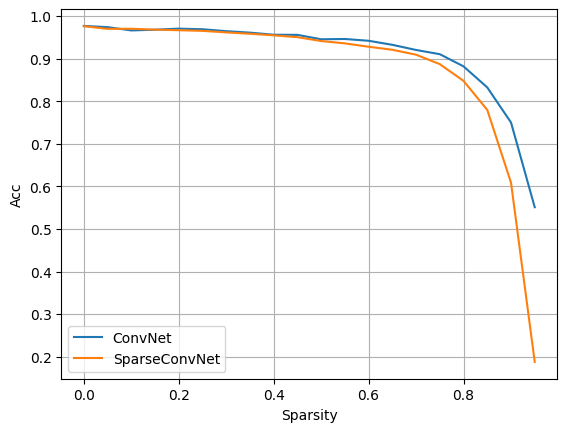

In [11]:
plt.plot(prob_list, acc_conv, label='ConvNet')
plt.plot(prob_list, acc_sparseconv, label='SparseConvNet')
plt.xlabel("Sparsity")
plt.ylabel("Acc")
plt.grid()
plt.legend()